<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization , MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow

In [3]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 96% 114M/119M [00:00<00:00, 168MB/s] 
100% 119M/119M [00:00<00:00, 129MB/s]


## Preprocesamiento de datos



In [5]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [6]:
input_size = (460, 460)

training_datagen = ImageDataGenerator(
    dtype='float32',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,)

test_datagen = ImageDataGenerator( dtype='float32')
validation_datagen = ImageDataGenerator( dtype='float32')

# Load and preprocess training data
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## Construcción del modelo

El modelo se construyó utilizando como base


In [7]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (460, 460, 3))

for layer in base_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
model = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(verbose = 1,
                               patience = 2,
                               restore_best_weights = True)
epochs = 100
history = model.fit(
    train_generator,
    verbose = 1,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping])



Epoch 1/100
 7/20 [=========>....................] - ETA: 25s - loss: 0.7190 - accuracy: 0.7589

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

In [18]:
model.evaluate(test_generator)

10/10 [==============================] - 6s 473ms/step - loss: 65.1230 - accuracy: 0.2317


[65.12299346923828, 0.23174603283405304]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

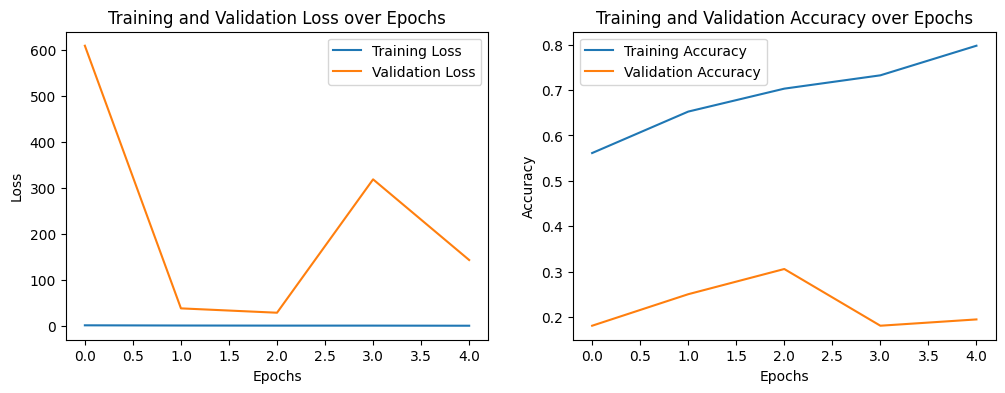

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

10/10 [==============================] - 8s 816ms/step


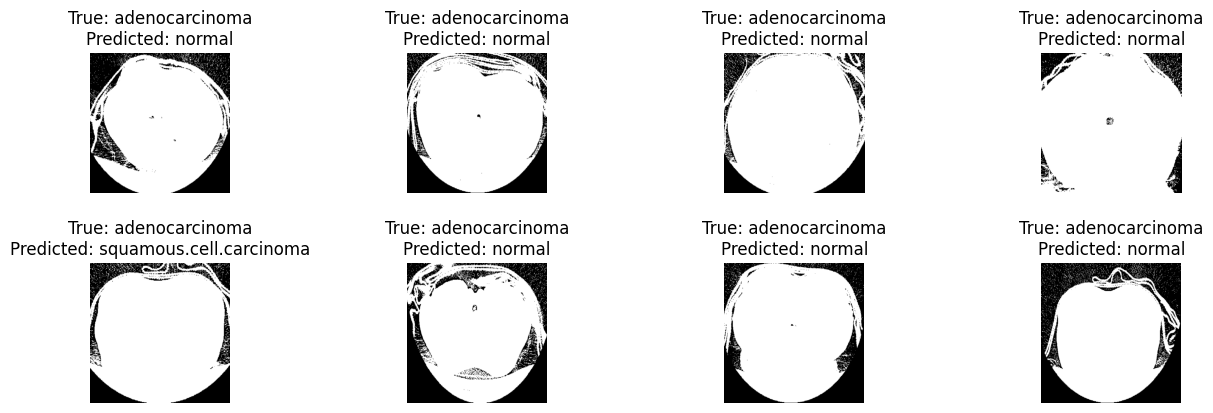

In [20]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[  0   0 109  11]
 [  0   0  44   7]
 [  0   0  49   5]
 [  0   0  83   7]]


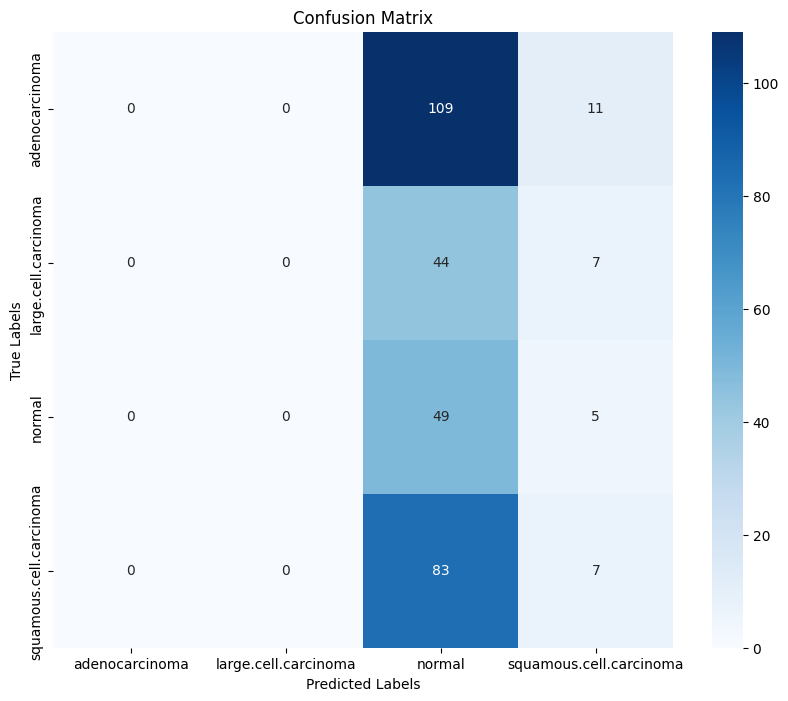

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()